# Clustering with the 20-Newsgroups Dataset
Authors: R. Edwards, J.Giles, N. Velzboer, E. Whitney and you! <br>
Purpose: Exploring different clustering approaches with the 20 newsgroup dataset, comprising of user questions and posts on different web forums (open source: http://qwone.com/~jason/20Newsgroups/)

In [1]:
# Import Relavent Libraries

## Python libraries 
import string
import time

## Data Manipulation
import pandas as pd
import numpy as np

## Plotting Data
import matplotlib.pyplot as plt

## Feature selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Dimensionality Reduction 
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from collections import Counter

## Clustering 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

## Get rid of pesky warnings
import warnings
warnings.filterwarnings('ignore')

## Set-up
Reading in data, creating pandas dataframe

In [161]:
# Sklearn maintains offers this data as part of their inbuilt learning sets.
#  We'll download the 'training' set,  however ignore the name 'train'. They 
# offer the data split into training and testing sets if you are trying to apply some classification approach 
# May take up to a minute to download
filter_topics = ['comp.graphics','comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x',
 'misc.forsale','rec.autos','rec.motorcycles',
 'rec.sport.baseball','rec.sport.hockey','sci.crypt',
 'sci.electronics','sci.med','sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',categories=filter_topics)

In [162]:
# Pull data into pandas dataframe. Non essential, but pandas dataframes are nice to work with
df_text_ng=pd.DataFrame(data={'text':newsgroups_train.data}, columns=['text'])

# Take subset of dataset to prevent memory/kernel/processing issues
row_lim = 2000
df_text_ng = df_text_ng.iloc[0:row_lim,:]

## Cleaning and pre-processing
We will apply the following pre-processing steps <br>
<ol>
<li> Remove unwanted characters
<li> Tokenisation and case sensitive 
<li> Stopwords
<li> Lemmitisation 
<ul>

In [163]:
# Standard NLTK stopwords list
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
            "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
            'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 
            'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
            'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
            'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 
            'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
            'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
            'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
            'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
            'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
            'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
            'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 
            'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
            'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
            'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
            'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
            'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren',
            "weren't", 'won', "won't", 'wouldn', "wouldn't", 'would']
# Add extras you want to remove here
custom_stops = ['subject', 'from', 'to', 'article', 'summary','nntp', 'posting',
                'host', 'lines', 'organisation', 'organization', 'scsi', 'writes',
                'university']
# Join two lists
our_stopwords = stopwords + custom_stops


In [164]:
pd.set_option('display.max_colwidth', 1000)
# Lower case
df_text_ng['text_lower'] = df_text_ng['text'].str.lower()
# Remove \n (newlines), and strings with emails or .com IP style addresses
df_text_ng['text_noemails'] = df_text_ng['text_lower'].replace(r"\n"," ",
                              regex=True).replace(r"\S*[@.]\S*\s?","", regex=True)
# Remove anything except letters and spaces
df_text_ng['text_punct'] = df_text_ng['text_noemails'].replace(r"[^a-z ]"," ",
                              regex=True)
# Split string into lists of words on the whitespace
df_text_ng['text_tokens'] = df_text_ng['text_punct'].str.split()
# Remove words not in our prederived list
df_text_ng['text_stop'] = df_text_ng['text_tokens'].apply(lambda x: [word 
                             for word in x if word not in our_stopwords])
# Rejoin into a string 
df_text_ng['text_clean'] = df_text_ng['text_stop'].apply(lambda x: ' '.join([word for word in x]))

In [165]:
print("Original record 1: \n\n")
print(df_text_ng['text'][0:1])
print("\n")
print("Cleaned record 1: \n\n")
print(df_text_ng['text_clean'][0:1])

Original record 1: 


0    From: ai598@cleveland.Freenet.Edu (Mike Sturdevant)\nSubject: Carrying crutches (was Re: Living\nArticle-I.D.: usenet.1pqhkl$g48\nReply-To: ai598@cleveland.Freenet.Edu (Mike Sturdevant)\nOrganization: Case Western Reserve University, Cleveland, OH (USA)\nLines: 18\nNNTP-Posting-Host: slc10.ins.cwru.edu\n\n\nIn a previous article, pooder@rchland.vnet.ibm.com (Don Fearn) says:\n\n>\n>When I broke my right leg in two places (not a motorcycle accident -- a \n>_car_ accident; who woulda thunk it?) I put my crutches on Gretchen's rear\n>rack.  I'm getting the metal rod pulled out on Friday and going back on \n>the crutches for six weeks.  I think crutches on the handlebars sound more \n>aesthetically pleasing.  How did you attach them?\n\n\n\tWhen I got my knee rebuilt I got back on the street bike ASAP. I put\nthe crutches on the rack and the passenger seat and they hung out back a\nLONG way. Just make sure they're tied down tight in front and no problemo.\n-- \nG

## Feature engineering
Below we'll create the three possible sets that may be used (There are other <br>methods
but these are the voting options) <br>
<ol>
<li> Set 1: Bag of words with Unigrams
<li> Set 2: Bag of words with Unigrams and bigrams
<li> Set 3: TF-IDF with unigrams
</ol> <br>
Uncomment the set you would like to create

In [58]:
#Uncomment this cell for Set 1
bogS1 = CountVectorizer()
X = bogS1.fit_transform(df_text_ng['text_clean'])
print(X.toarray())
print("First 20 features:....\n")
print(bogS1.get_feature_names()[0:20])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
First 20 features:....

['aa', 'aaa', 'aaahhhh', 'aalternate', 'aam', 'aamir', 'aams', 'aan', 'aangegeven', 'aantal', 'aarhus', 'aaron', 'aas', 'aazo', 'ab', 'abad', 'abandon', 'abandond', 'abandoned', 'abberley']


In [8]:
#Uncomment this cell for Set 2
bogS2 = CountVectorizer(ngram_range=(1,2))
X = bogS2.fit_transform(df_text_ng['text_clean'])
print("First 20 features:....\n")
print(bogS2.get_feature_names()[0:20])

First 20 features:....

['aa', 'aa also', 'aa nd', 'aa play', 'aa season', 'aaa', 'aaa already', 'aaa batteries', 'aaa besides', 'aaa cal', 'aaa certainly', 'aaa club', 'aaa free', 'aaa level', 'aaa like', 'aaa longer', 'aaa players', 'aaa probably', 'aaa see', 'aaa talking']


In [166]:
#Uncomment this cell for Set 3
tfidfvect = TfidfVectorizer()
X = tfidfvect.fit_transform(df_text_ng['text_clean'])
print("First 20 features:....\n")
print(tfidfvect.get_feature_names()[0:20])

First 20 features:....

['aa', 'aaa', 'aaahhhh', 'aalternate', 'aam', 'aamir', 'aams', 'aan', 'aangegeven', 'aantal', 'aarhus', 'aaron', 'aas', 'aazo', 'ab', 'abad', 'abandon', 'abandond', 'abandoned', 'abberley']


## Dimensionality reduction 

### LDA

In [59]:
n_components = 100

In [172]:
# LDA
print("Performing dimensionality reduction using LDA...")

start = time.time()

lda = LatentDirichletAllocation(n_components=n_components, random_state=0, evaluate_every=1)
lda_model = lda.fit(X)
X_DR = lda.fit_transform(X)

end = time.time()
duration = np.round(end - start)
print("LDA duration: %i" %(duration))
# plt.plot(X_DR.max(axis=1),'o')

Performing dimensionality reduction using LDA...
LDA duration: 69


### LSA

Performing dimensionality reduction using LSA...
LDA duration: 2
Explained variance of the SVD step: 16%


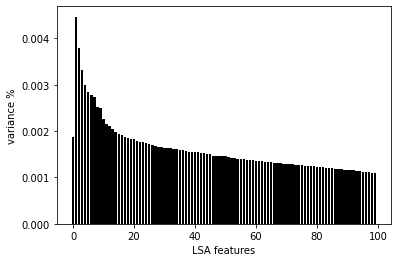

In [167]:
# LSA
## Prepare data for clustering

print("Performing dimensionality reduction using LSA...")

start = time.time()

# # Vectorizer results are normalized, which makes KMeans behave as
# # spherical k-means for better results. Since LSA/SVD results are
# # not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_array = X.toarray()
X_DR = lsa.fit_transform(X)

end = time.time()
duration = np.round(end - start)
print("LDA duration: %i" %(duration))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
     int(explained_variance * 100)))

# Plot the explained variances
features = range(svd.n_components)

plt.bar(features, svd.explained_variance_ratio_, color='black')
plt.xlabel('LSA features')
plt.ylabel('variance %');


### PCA

Performing dimensionality reduction using PCA...
Explained variance of the PCA: 10%
LDA duration: 8
The shape of X_DR is:  (2000, 50)


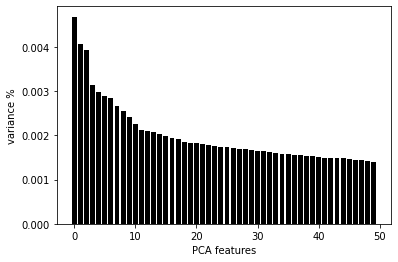

In [13]:
# PCA

## Prepare data for clustering

print("Performing dimensionality reduction using PCA...")

start = time.time()

pca = PCA(n_components=n_components)
X_DR = pca.fit_transform(X.toarray())
principalDf = pd.DataFrame(data = X_DR)

print("Explained variance of the PCA: {}%".format(
     int(pca.explained_variance_ratio_.sum() * 100)))

end = time.time()
duration = np.round(end - start)
print("LDA duration: %i" %(duration))

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %');
print('The shape of X_DR is: ', X_DR.shape)
#plt.xticks(features)


## Clustering

### Kmeans

In [75]:
# Initialise Modelling Parameters

## Number of CLusters
K = 14

## Method for Initialisation
init='k-means++' ## k-means++ selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.

## The number of initializations to perform. The best results are kept.
n_init=10

In [76]:
## Create model instance
model_instance = KMeans(n_clusters = K,
                        init=init,
                        n_init=n_init
                       )

## Fit data to model
model = model_instance.fit(X_DR)

## Get labels for evaluation
labels = model.labels_

### Gaussian Mixture Models

In [74]:
# Initialise Modelling Parameters

## Number of CLusters
K = 14

## String describing the type of covariance parameters to use.
covariance_type='full' ## Full means each component has its own general covariance matrix

## The number of initializations to perform. The best results are kept.
n_init=10

In [26]:
## Create model instance
model_instance = GaussianMixture(n_components=K
                                , n_init=n_init
                                , covariance_type=covariance_type
                                )

## Fit data to model
model = model_instance.fit(X_DR)

## Get labels for evaluation
labels = model.predict(X_DR)

### DBSCAN

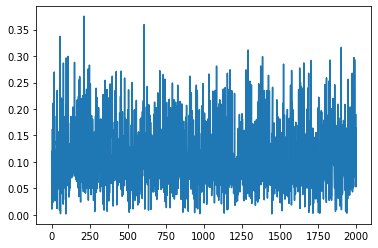

In [176]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_DR)
distances, indices = nbrs.kneighbors(X_DR)

distances = distances[:,1]
plt.plot(distances)


In [183]:
# Initialise Modelling Parameters

## The maximum distance between two samples for one to be considered as in the neighborhood of the other.
eps = 0.1

## The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.
min_samples = 2

In [184]:
## Create model instance
model_instance = DBSCAN(eps=eps
                        , min_samples=min_samples
                        )

## Fit data to model
model = model_instance.fit(X_DR)

## Get labels for evaluation
labels = model.labels_

## Evaluation

In [185]:
# Silhouette Score
silhouette_score = metrics.silhouette_score(X_DR
                                            , labels
                                           )
print("Silhouette Score:\t" + str(silhouette_score))

Silhouette Score:	0.011289838995966512


In [64]:
# Davies-Bouldin Score
davies_bouldin_score = metrics.davies_bouldin_score(X_DR
                                                    , labels
                                                   )

print("Davies-Bouldin Score:\t" + str(davies_bouldin_score))

Davies-Bouldin Score:	1.7726787244060809


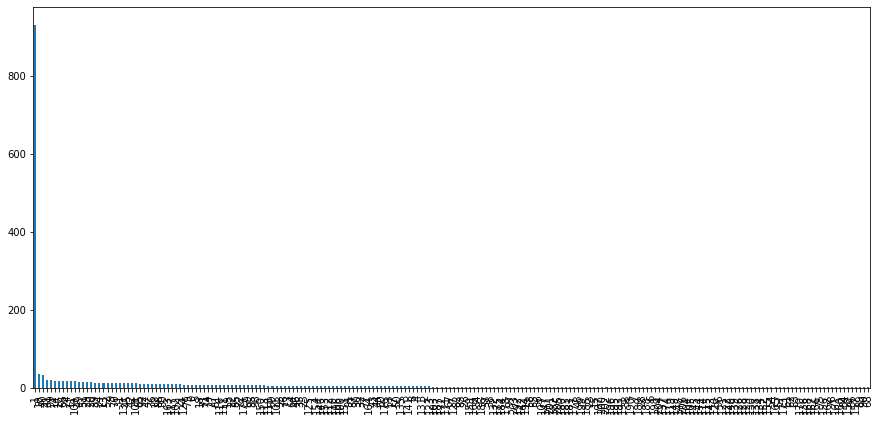

In [186]:
# Coefficient of Variation
## Assign Data points with their clusters
df_text_ng['cluster'] = labels
df_text_ng['cluster'].value_counts().plot(kind='bar', figsize=(15,7))

In [187]:
# Top Frequency Words per Cluster
df_text_ng[['text_clean', 'cluster']]

# Get distinct clusters ordered from highest frequency to lowest frequecy
clusters = df_text_ng['cluster'].value_counts().keys().tolist()

# Number of top words to print
print_top_x_words = 5

# for each cluster
for i in range (0, len(clusters)):
    
    # Print Cluster Header
    cluster = clusters[i]
    num_terms = df_text_ng['cluster'].value_counts().tolist()[i]
    print("Cluster: " + str(cluster) + "\t Number of Terms: " + str(num_terms))
    
    # Print Frequency Counts
    vectorizer = CountVectorizer().fit(df_text_ng[df_text_ng['cluster']==cluster]['text_clean'].values)
    cluster_bog = vectorizer.transform(df_text_ng[df_text_ng['cluster']==cluster]['text_clean'].values)
    word_sum = cluster_bog.sum(axis=0)
    words_freq = [(word, word_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print_str = ""
    for item in words_freq_sorted[:print_top_x_words]:
        print_str += (str(item[0]) + " (" + str(item[1]) + ")\t")
    print(print_str + "\n")

Cluster: -1	 Number of Terms: 930
one (688)	db (560)	like (549)	get (430)	use (385)	

Cluster: 10	 Number of Terms: 35
get (22)	see (20)	one (20)	like (16)	know (16)	

Cluster: 40	 Number of Terms: 33
one (15)	also (14)	buy (13)	may (12)	motif (12)	

Cluster: 41	 Number of Terms: 20
one (11)	anyone (10)	new (10)	know (10)	get (10)	

Cluster: 99	 Number of Terms: 19
jj (13)	one (10)	like (7)	also (7)	use (7)	

Cluster: 14	 Number of Terms: 18
may (15)	new (12)	one (12)	june (10)	like (9)	

Cluster: 16	 Number of Terms: 17
like (8)	anyone (7)	one (6)	stereo (6)	center (5)	

Cluster: 66	 Number of Terms: 16
like (12)	graeme (11)	space (10)	one (8)	ta (7)	

Cluster: 24	 Number of Terms: 16
access (11)	windows (9)	know (7)	one (7)	use (7)	

Cluster: 11	 Number of Terms: 16
data (20)	could (16)	use (12)	andrew (11)	input (11)	

Cluster: 109	 Number of Terms: 16
xxxx (26)	ff (21)	hard (12)	line (9)	could (8)	

Cluster: 49	 Number of Terms: 15
got (9)	windows (9)	david (7)	end (7)	time (7)	

C

In [84]:
for i in range(0,K):
  print('Cluster',i)
  print(df_text_ng[df_text_ng['cluster'] == i].head(5))

Cluster 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              